In [17]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [18]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


## Importing libraries

In [19]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')
import matplotlib.image as mpimg
from PIL import Image
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.layers import *
from tensorflow.python.keras.models import * 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#set seed
from numpy.random import seed
seed(10)
tf.random.set_seed(10)

print('Imported Successfully, No problem')



Imported Successfully, No problem


## Plot 6 random images from the train folder

xray_dataset_covid19/train\NORMAL\IM-0049-0001.jpeg
xray_dataset_covid19/train\NORMAL\IM-0059-0001.jpeg
xray_dataset_covid19/train\PNEUMONIA\5CBC2E94-D358-401E-8928-965CCD965C5C.jpeg
xray_dataset_covid19/train\NORMAL\IM-0102-0001.jpeg
xray_dataset_covid19/train\PNEUMONIA\7D2CF6CE-F529-4470-8356-D33FFAF98600.jpeg
xray_dataset_covid19/train\PNEUMONIA\5CBC2E94-D358-401E-8928-965CCD965C5C.jpeg


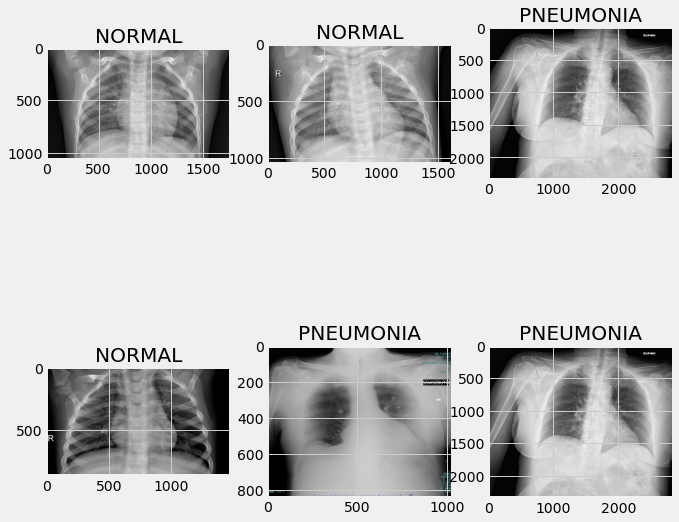

In [20]:
img_folder="xray_dataset_covid19/train"
plt.figure(figsize=(10,10))
for i in range(1,7):
 class_ = random.choice(os.listdir(img_folder))
 class_path= os.path.join(img_folder, class_)
 file=random.choice(os.listdir(class_path))
#  print(file)
 image_path= os.path.join(class_path,file)
 print(image_path)
 img= mpimg.imread(image_path)
 ax=plt.subplot(2,3,(i))
 plt.imshow(img,cmap='gray')
 ax.title.set_text(class_)

## Preprocess the images

In [21]:

def create_dataset(img_folders,IMG_WIDTH,IMG_HEIGHT):
    
    
    img_data_array=[]
    class_name=[]
    n=0
    for dirname, _, filenames in os.walk(img_folders):
        for filename in filenames:
            img_path= os.path.join(dirname, filename)
            #read the image
            image = cv2.imread(img_path)
            # BGR is converted to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMG_WIDTH,IMG_HEIGHT))
            image= np.array(image)
            image = image.astype('float32')
            image /= 255
            img_data_array.append(image)
            class_=str(dirname).split("\\")
            class_name.append(class_[1])
            n+=1
            
            
            
    return img_data_array, class_name,n# extract the image array and class name

# information about dataset

In [22]:
for _set in ['train', 'test']:
    n_normal = len(os.listdir('xray_dataset_covid19/' + _set + '/NORMAL'))
    n_infected = len(os.listdir('xray_dataset_covid19/' + _set + '/PNEUMONIA'))
    print('Set: {}, normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infected))

Set: train, normal images: 74, pneumonia images: 74
Set: test, normal images: 20, pneumonia images: 20


#  Load the train and test data

In [34]:
IMG_WIDTH= 224
IMG_HEIGHT=224
train_path='xray_dataset_covid19/train'
test_path='xray_dataset_covid19/test'
train_img,train_label,num_img=create_dataset(train_path,IMG_WIDTH,IMG_HEIGHT)
test_img,test_label,num_test_img=create_dataset(test_path,IMG_WIDTH,IMG_HEIGHT)
# print(train_label)

# plot random pictures after preprocessing

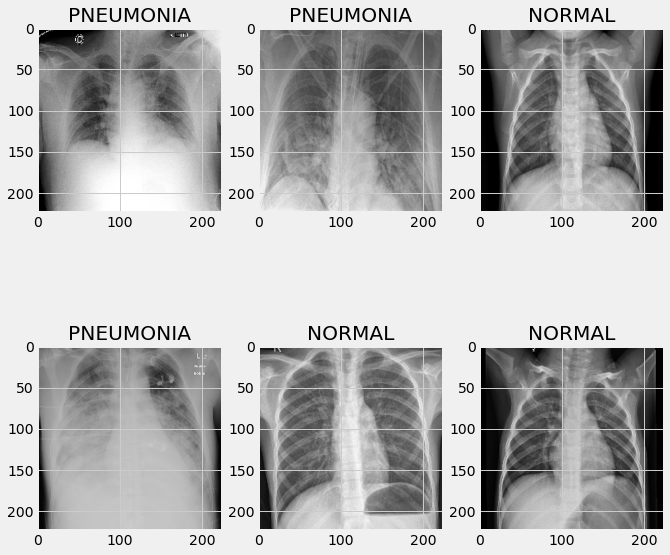

In [36]:
plt.figure(figsize=(10,10))
for i in range(6):
    random_num = random.randint(0,num_img)
    ax=plt.subplot(2,3,(i+1))
    plt.imshow(train_img[random_num])
    ax.title.set_text(train_label[random_num])

# Convert text labels to numeric

In [25]:
target_dict={'NORMAL':0,'PNEUMONIA':1}
print(target_dict)
train_label= [target_dict[train_label[i]] for i in range(len(train_label))]
train_label=np.array(train_label)
train_img=np.array(train_img)
test_label= [target_dict[test_label[i]] for i in range(len(test_label))]
test_label=np.array(test_label)
test_img=np.array(test_img)

{'NORMAL': 0, 'PNEUMONIA': 1}


In [26]:
test_label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

# Define Model

In [27]:
#Saving best model while monitoring accuracy
model_chkpt = ModelCheckpoint('best_mod.h5', save_best_only=True, monitor='accuracy')

#early stopping for preventing overfitting
early_stopping = EarlyStopping(monitor='loss', restore_best_weights=False, patience=10)

#Define a Sequential() model.
model = Sequential()
# Add the first layer: 32 is the number of filters; kernel_size specifies the size of our filters;
# activation specifies the activation function;input_shape specifies what type of input we are going to pass to the network
model.add(Conv2D(32, kernel_size=(3,3), activation="relu",input_shape=(IMG_WIDTH,IMG_HEIGHT,3)))
#Deine a Max pooling: kernel_size, which specified the size of the pooling window.
model.add(MaxPooling2D(pool_size=(2,2)))
#Dropout. This means that the model will not overfit, as some neurons randomly will not be selected for activation. 
#This prevents the model from overfitting.
model.add(Dropout(0.25))
#Repeate the above steps to make a deeper network.
# Second layer: specified 64 filters(must be a power of 2)
model.add(Conv2D(64, kernel_size=(3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
#third layer 
model.add(Conv2D(128, kernel_size=(3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
# Flatten layer
model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.5))
# Create an output sigmoid function
model.add(Dense(1, activation="sigmoid"))
#Compile the model: binary_crossentropy because this is a binary classification problem; adam as the optimizer; the metric that we want to monitor is accuracy.
model.compile(loss="binary_crossentropy", optimizer="adam",metrics = ["accuracy"])
# Print the model architecture to take a look at the number of parameters that the model will learn.
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 52, 52, 128)      

# training model

In [28]:
fitting= model.fit(train_img, train_label, 
          validation_split=0.10, 
          epochs=25, 
          batch_size=32, 
          shuffle=True, 
          callbacks=[model_chkpt, early_stopping]
        )

Epoch 1/25
5/5 [==============================] - 6s 945ms/step - loss: 2.9559 - accuracy: 0.5414 - val_loss: 0.6857 - val_accuracy: 0.9333
Epoch 2/25
5/5 [==============================] - 5s 986ms/step - loss: 0.6896 - accuracy: 0.5338 - val_loss: 0.6902 - val_accuracy: 0.9333
Epoch 3/25
5/5 [==============================] - 5s 876ms/step - loss: 0.6650 - accuracy: 0.5188 - val_loss: 0.8454 - val_accuracy: 0.0000e+00
Epoch 4/25
5/5 [==============================] - 5s 889ms/step - loss: 0.6353 - accuracy: 0.6316 - val_loss: 0.6115 - val_accuracy: 1.0000
Epoch 5/25
5/5 [==============================] - 5s 913ms/step - loss: 0.5424 - accuracy: 0.7744 - val_loss: 0.6059 - val_accuracy: 0.9333
Epoch 6/25
5/5 [==============================] - 5s 900ms/step - loss: 0.4184 - accuracy: 0.8647 - val_loss: 0.4340 - val_accuracy: 1.0000
Epoch 7/25
5/5 [==============================] - 5s 877ms/step - loss: 0.3876 - accuracy: 0.8120 - val_loss: 0.1116 - val_accuracy: 1.0000
Epoch 8/25
5/5 [

# graphs for the loss function and accuracy, for the train and validation sample

<AxesSubplot:>

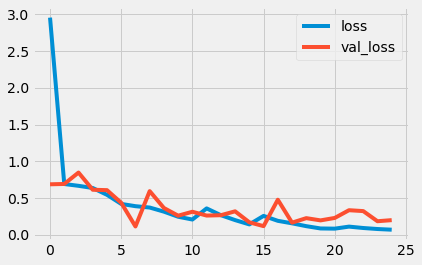

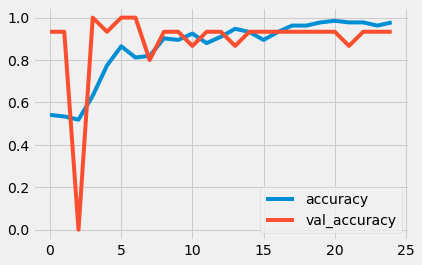

In [29]:
training_frame = pd.DataFrame(fitting.history)
training_frame.loc[:, ['loss', 'val_loss']].plot()
training_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

# Prediction

In [30]:
#prediction on test set
pred = model.predict(test_img,batch_size=32)
label = [int(p>=0.5) for p in pred]
label

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

## Performance Evaluation

In [31]:
#Performance Evaluation - Accuracy, Classification Report & Confusion Matrix
#Test Accuracy Score
print ('Test Accuracy Score : ', accuracy_score(label,test_label)*100, '\n')

# #precision, recall report
print ('Classification Report :\n\n' ,classification_report(label, test_label))
print("---------------------------------------------------------------")
cm = confusion_matrix(test_label, label)
print("Confusion matrix:\n")
print(cm)
tn, fp, fn, tp = cm.ravel()
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

Test Accuracy Score :  100.0 

Classification Report :

               precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

---------------------------------------------------------------
Confusion matrix:

[[20  0]
 [ 0 20]]
Precision: 100.0%
Recall: 100.0%
F1-score: 100.0


In [32]:
# train Accuracy Score
print("training accuracy :\n")
print(fitting.history['accuracy'][-1]*100)

training accuracy :

97.74436354637146
